<a href="https://colab.research.google.com/github/girishthorat/People-Counting/blob/main/HDDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:

from numpy import asarray
from numpy import save

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from typing import TypeVar 
import typing as npt
import cv2
import argparse




# NN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images= np.load('/content/drive/MyDrive/HDDA_Project/images.npy')


(2000, 480, 640, 3)

In [ ]:
label= np.load('/content/drive/MyDrive/HDDA_Project/labels.npy')

In [ ]:
for i in range(100):
  plt.imshow(images[i])
  plt.show()

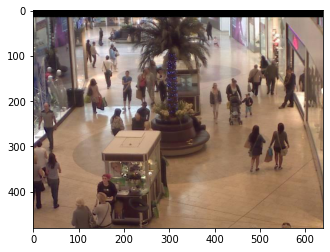

In [ ]:
plt.imshow(images[1])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images[0:1000], label[0:1000])

In [ ]:
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train = x_train / 255.
# x_test = x_test / 255.


(750, 480, 640, 3)

In [ ]:
batch_size = 16
epochs = 5

In [ ]:

model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(480,640,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 478, 638, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 239, 319, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 237, 317, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 118, 158, 128)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 118, 158, 128)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2386432)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [ ]:
model_train = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))

Epoch 1/5
47/47 [==============================] - 9s 187ms/step - loss: 643.1295 - mae: 643.6214 - val_loss: 4.2318 - val_mae: 4.7094
Epoch 2/5
47/47 [==============================] - 8s 175ms/step - loss: 4.0226 - mae: 4.4971 - val_loss: 3.9076 - val_mae: 4.3853
Epoch 3/5
47/47 [==============================] - 8s 175ms/step - loss: 2.8074 - mae: 3.2711 - val_loss: 3.2486 - val_mae: 3.7181
Epoch 4/5
47/47 [==============================] - 8s 175ms/step - loss: 2.4978 - mae: 2.9603 - val_loss: 3.0951 - val_mae: 3.5610
Epoch 5/5
47/47 [==============================] - 8s 175ms/step - loss: 1.6773 - mae: 2.1180 - val_loss: 2.6753 - val_mae: 3.1405


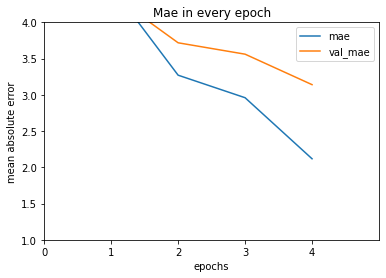

In [ ]:
 # plot mae
plt.plot(model_train.history['mae'])
plt.plot(model_train.history['val_mae'])
plt.legend(['mae', 'val_mae'])
plt.ylim(1, 4)
plt.xlim(0, 5)

plt.xticks(np.arange(0,5, 1))

plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.title('Mae in every epoch')
plt.show()

In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=1)

8/8 [==============================] - 1s 108ms/step - loss: 2.6753 - mae: 3.1405


# Convert to Gray



In [ ]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


    

In [ ]:
images_gray1=[]
for k in range(1000):
  images_gray1.append(rgb2gray(images[k]))
images_gray = np.array(images_gray1)

  

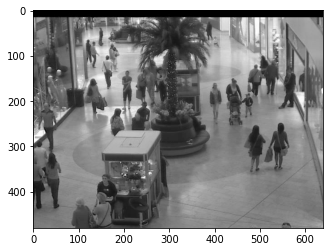

In [ ]:
gray = rgb2gray(images[1])    
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
save('images_gray.npy', images_gray) # saved once

# OTSU

In [ ]:
def otsu(gray):
  pixel_number = gray.shape[0] * gray.shape[1]
  mean_weight = 1.0/pixel_number
  his, bins = np.histogram(gray, np.arange(0,257))
  final_thresh = -1
  final_value = -1
  intensity_arr = np.arange(256)
  for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
    pcb = np.sum(his[:t])
    pcf = np.sum(his[t:])
    Wb = pcb * mean_weight
    Wf = pcf * mean_weight

    mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
    muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
    #print mub, muf
    value = Wb * Wf * (mub - muf) ** 2

    if value > final_value:
      final_thresh = t
      final_value = value
  final_img = gray.copy()
  #print(final_thresh)
  final_img[gray > final_thresh] = 255
  final_img[gray < final_thresh] = 0
  return final_img
 

In [ ]:
with np.printoptions(threshold=np.inf):
  print(otsu(images_gray[0]))


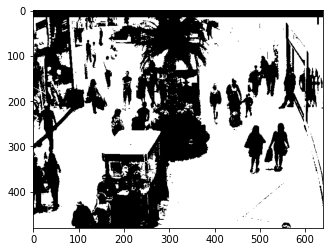

In [ ]:
otsu_bw = otsu(images_gray[1])    
plt.imshow(otsu_bw, cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
images_otsu1=[]
for k in range(1000):
  images_otsu1.append(otsu(images[k]))
images_otsu = np.array(images_otsu1)

In [ ]:
save('images_otsu.npy', images_otsu) # saved once

# Sobel Operator


In [ ]:
def sobel_edge_detection(img):
  new_image_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
 
  new_image_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
 
    
  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
 
  gradient_magnitude *= 255.0 / gradient_magnitude.max()
 
  return gradient_magnitude
  
 
 


In [ ]:
a=sobel_edge_detection(images_gray[1])

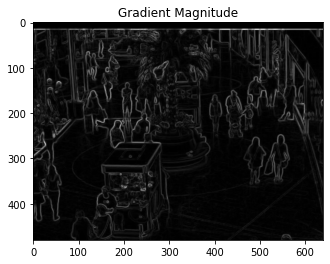

In [ ]:
plt.imshow(a, cmap='gray')
plt.title("Gradient Magnitude")
plt.show()

In [ ]:
images_sobel1=[]
for k in range(1000):
  images_sobel1.append(sobel_edge_detection(images[k]))
images_sobel = np.array(images_sobel1)

In [ ]:
save('images_sobel.npy', images_sobel) # saved once

In [ ]:
images_sobel= np.load('/content/drive/MyDrive/HDDA_Project/images_sobel.npy')


(1000, 480, 640)

# NN Gray

In [ ]:
images= np.load('/content/drive/MyDrive/HDDA_Project/images_gray.npy')
label= np.load('/content/drive/MyDrive/HDDA_Project/labels.npy')
label= label[0:1000]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, label)
x_train = x_train.reshape(-1, 480, 640, 1)
x_test = x_test.reshape(-1, 480, 640, 1)

In [ ]:
batch_size = 16
epochs = 5


In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(480,640,1), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 478, 638, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 239, 319, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 237, 317, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 118, 158, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 158, 128)     0         
_________________________________________________________________
flatten (Flatten)            (None, 2386432)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [ ]:
model_train = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))

Epoch 1/5
47/47 [==============================] - 43s 238ms/step - loss: 6903.6137 - mae: 6904.1113 - val_loss: 6.8247 - val_mae: 7.3143
Epoch 2/5
47/47 [==============================] - 9s 190ms/step - loss: 6.8862 - mae: 7.3721 - val_loss: 5.7441 - val_mae: 6.2224
Epoch 3/5
47/47 [==============================] - 9s 191ms/step - loss: 3.7694 - mae: 4.2397 - val_loss: 2.6917 - val_mae: 3.1595
Epoch 4/5
47/47 [==============================] - 9s 190ms/step - loss: 2.0284 - mae: 2.4885 - val_loss: 2.8697 - val_mae: 3.3296
Epoch 5/5
47/47 [==============================] - 9s 190ms/step - loss: 1.5319 - mae: 1.9860 - val_loss: 2.1425 - val_mae: 2.5991


In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=1)

8/8 [==============================] - 1s 138ms/step - loss: 2.1425 - mae: 2.5991


# NN Otsu

In [ ]:
images= np.load('/content/drive/MyDrive/HDDA_Project/images_otsu.npy')
label= np.load('/content/drive/MyDrive/HDDA_Project/labels.npy')
label= label[0:1000]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, label)
x_train = x_train.reshape(-1,480, 640, 1)
x_test = x_test.reshape(-1,480, 640, 1)

In [ ]:
batch_size = 16
epochs = 5

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(480,640,1), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 478, 638, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 239, 319, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 237, 317, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 118, 158, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 158, 128)     0         
_________________________________________________________________
flatten (Flatten)            (None, 2386432)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [ ]:
model_train = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))

Epoch 1/5
47/47 [==============================] - 44s 247ms/step - loss: 13853.9953 - mae: 13854.4939 - val_loss: 4.4181 - val_mae: 4.8968
Epoch 2/5
47/47 [==============================] - 9s 191ms/step - loss: 6.8898 - mae: 7.3779 - val_loss: 3.4161 - val_mae: 3.8965
Epoch 3/5
47/47 [==============================] - 9s 190ms/step - loss: 3.2848 - mae: 3.7618 - val_loss: 2.6949 - val_mae: 3.1605
Epoch 4/5
47/47 [==============================] - 9s 191ms/step - loss: 2.4426 - mae: 2.9011 - val_loss: 2.6553 - val_mae: 3.1144
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 1.8658 - mae: 2.3234 - val_loss: 2.3618 - val_mae: 2.8147


In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=1)

8/8 [==============================] - 2s 142ms/step - loss: 2.3618 - mae: 2.8147


# NN Sobel

In [ ]:
images= np.load('/content/drive/MyDrive/HDDA_Project/images_sobel.npy')
label= np.load('/content/drive/MyDrive/HDDA_Project/labels.npy')
label= label[0:1000]

In [ ]:
images.shape

(1000, 480, 640)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, label)
x_train = x_train.reshape(-1,480, 640, 1)
x_test = x_test.reshape(-1,480, 640, 1)

In [ ]:
batch_size = 16
epochs = 5

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(480,640,1), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 478, 638, 64)      640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 239, 319, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 237, 317, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 118, 158, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 118, 158, 128)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2386432)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
model_train = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))

Epoch 1/5
47/47 [==============================] - 43s 241ms/step - loss: 2221.9325 - mae: 2222.4262 - val_loss: 5.9512 - val_mae: 6.4462
Epoch 2/5
47/47 [==============================] - 9s 192ms/step - loss: 3.0414 - mae: 3.5071 - val_loss: 3.2033 - val_mae: 3.6810
Epoch 3/5
47/47 [==============================] - 9s 191ms/step - loss: 2.1169 - mae: 2.5732 - val_loss: 4.0464 - val_mae: 4.5274
Epoch 4/5
47/47 [==============================] - 9s 191ms/step - loss: 2.2474 - mae: 2.7088 - val_loss: 3.0867 - val_mae: 3.5423
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 1.9215 - mae: 2.3808 - val_loss: 2.2230 - val_mae: 2.6828


In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=1)

8/8 [==============================] - 1s 140ms/step - loss: 2.2230 - mae: 2.6828
